In [139]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm
from torch.optim import lr_scheduler

In [140]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [141]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [142]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


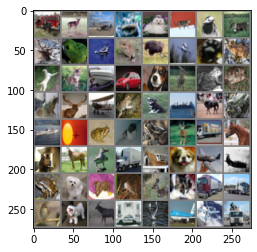

truck deer  plane frog  dog   cat   bird  deer  deer  frog  plane frog  bird  plane cat   frog  dog   cat   ship  car   dog   deer  frog  frog  frog  deer  plane frog  dog   ship  horse frog  ship  plane frog  dog   frog  deer  truck horse cat   horse bird  truck cat   dog   plane plane frog  dog   dog   frog  deer  cat   truck truck bird  dog   deer  car   bird  plane plane truck


In [143]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [144]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.dropout(F.tanh(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [145]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.1,momentum = 0):
    history = []
    lrs = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    return history, end, lrs

In [146]:
begin = time.time()
history, end, lrs = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:10<00:00, 61.54it/s]


Epoch [0], Time taken :12.4256, train_loss : 1.7876, train_acc: 0.3441, val_loss: 1.6717, val_acc: 0.3821


100%|██████████| 657/657 [00:10<00:00, 64.61it/s]


Epoch [1], Time taken :12.0400, train_loss : 1.3667, train_acc: 0.5084, val_loss: 1.5484, val_acc: 0.4652


100%|██████████| 657/657 [00:10<00:00, 64.83it/s]


Epoch [2], Time taken :12.1689, train_loss : 1.2027, train_acc: 0.5739, val_loss: 1.3734, val_acc: 0.5139


100%|██████████| 657/657 [00:10<00:00, 63.37it/s]


Epoch [3], Time taken :12.4716, train_loss : 1.1038, train_acc: 0.6140, val_loss: 1.2392, val_acc: 0.5648


100%|██████████| 657/657 [00:10<00:00, 64.47it/s]


Epoch [4], Time taken :12.0911, train_loss : 1.0249, train_acc: 0.6467, val_loss: 1.1748, val_acc: 0.5891


100%|██████████| 657/657 [00:10<00:00, 64.41it/s]


Epoch [5], Time taken :12.5297, train_loss : 0.9695, train_acc: 0.6650, val_loss: 1.2196, val_acc: 0.5857


100%|██████████| 657/657 [00:10<00:00, 65.05it/s]


Epoch [6], Time taken :11.9131, train_loss : 0.9246, train_acc: 0.6818, val_loss: 1.0847, val_acc: 0.6199


100%|██████████| 657/657 [00:09<00:00, 66.08it/s]


Epoch [7], Time taken :11.6851, train_loss : 0.8762, train_acc: 0.6984, val_loss: 1.0274, val_acc: 0.6378


100%|██████████| 657/657 [00:10<00:00, 60.10it/s]


Epoch [8], Time taken :12.7005, train_loss : 0.8389, train_acc: 0.7139, val_loss: 1.0577, val_acc: 0.6403


100%|██████████| 657/657 [00:09<00:00, 66.24it/s]


Epoch [9], Time taken :11.7103, train_loss : 0.8138, train_acc: 0.7237, val_loss: 0.9963, val_acc: 0.6609


100%|██████████| 657/657 [00:10<00:00, 65.41it/s]


Epoch [10], Time taken :11.9000, train_loss : 0.7775, train_acc: 0.7350, val_loss: 0.9890, val_acc: 0.6655


100%|██████████| 657/657 [00:10<00:00, 63.03it/s]


Epoch [11], Time taken :12.3693, train_loss : 0.7500, train_acc: 0.7444, val_loss: 1.1123, val_acc: 0.6344


100%|██████████| 657/657 [00:09<00:00, 67.06it/s]


Epoch [12], Time taken :11.8821, train_loss : 0.7244, train_acc: 0.7528, val_loss: 0.9806, val_acc: 0.6714


100%|██████████| 657/657 [00:09<00:00, 68.43it/s]


Epoch [13], Time taken :11.6979, train_loss : 0.6994, train_acc: 0.7627, val_loss: 1.0155, val_acc: 0.6630


100%|██████████| 657/657 [00:10<00:00, 61.76it/s]


Epoch [14], Time taken :12.5058, train_loss : 0.6790, train_acc: 0.7714, val_loss: 0.9702, val_acc: 0.6729


100%|██████████| 657/657 [00:10<00:00, 65.51it/s]


Epoch [15], Time taken :11.7865, train_loss : 0.6606, train_acc: 0.7746, val_loss: 0.9822, val_acc: 0.6775


100%|██████████| 657/657 [00:10<00:00, 63.80it/s]


Epoch [16], Time taken :12.2485, train_loss : 0.6358, train_acc: 0.7819, val_loss: 0.9942, val_acc: 0.6706


100%|██████████| 657/657 [00:10<00:00, 65.68it/s]


Epoch [17], Time taken :11.8124, train_loss : 0.6218, train_acc: 0.7895, val_loss: 0.9456, val_acc: 0.6941


100%|██████████| 657/657 [00:10<00:00, 64.40it/s]


Epoch [18], Time taken :12.0192, train_loss : 0.6067, train_acc: 0.7941, val_loss: 0.9630, val_acc: 0.6874


100%|██████████| 657/657 [00:10<00:00, 61.64it/s]


Epoch [19], Time taken :12.4339, train_loss : 0.5935, train_acc: 0.7979, val_loss: 0.9757, val_acc: 0.6775


100%|██████████| 657/657 [00:10<00:00, 65.10it/s]


Epoch [20], Time taken :11.9246, train_loss : 0.5776, train_acc: 0.8035, val_loss: 0.9731, val_acc: 0.6795


100%|██████████| 657/657 [00:10<00:00, 64.38it/s]


Epoch [21], Time taken :12.2466, train_loss : 0.5661, train_acc: 0.8085, val_loss: 1.0123, val_acc: 0.6734


100%|██████████| 657/657 [00:10<00:00, 61.99it/s]


Epoch [22], Time taken :12.6662, train_loss : 0.5538, train_acc: 0.8148, val_loss: 0.9673, val_acc: 0.6876


100%|██████████| 657/657 [00:09<00:00, 66.84it/s]


Epoch [23], Time taken :11.7135, train_loss : 0.5427, train_acc: 0.8140, val_loss: 0.9817, val_acc: 0.6825


100%|██████████| 657/657 [00:09<00:00, 66.45it/s]


Epoch [24], Time taken :11.6470, train_loss : 0.5345, train_acc: 0.8191, val_loss: 0.9881, val_acc: 0.6870


100%|██████████| 657/657 [00:10<00:00, 62.21it/s]


Epoch [25], Time taken :12.3586, train_loss : 0.5257, train_acc: 0.8220, val_loss: 0.9648, val_acc: 0.6917


100%|██████████| 657/657 [00:10<00:00, 64.68it/s]


Epoch [26], Time taken :11.9406, train_loss : 0.5202, train_acc: 0.8240, val_loss: 0.9883, val_acc: 0.6841


100%|██████████| 657/657 [00:10<00:00, 60.20it/s]


Epoch [27], Time taken :12.8764, train_loss : 0.5078, train_acc: 0.8279, val_loss: 0.9774, val_acc: 0.6924


100%|██████████| 657/657 [00:10<00:00, 65.65it/s]


Epoch [28], Time taken :11.8664, train_loss : 0.5104, train_acc: 0.8257, val_loss: 0.9999, val_acc: 0.6913


100%|██████████| 657/657 [00:09<00:00, 66.41it/s]


Epoch [29], Time taken :11.6581, train_loss : 0.4974, train_acc: 0.8310, val_loss: 0.9905, val_acc: 0.6924
Finished Training in 363.7727937698364secs


In [147]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

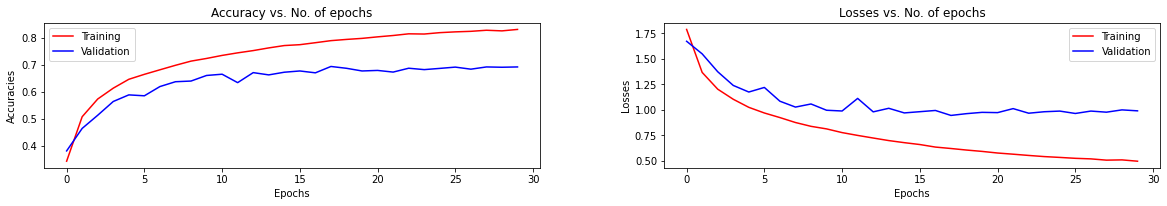

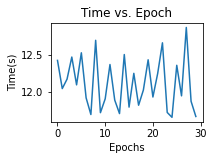

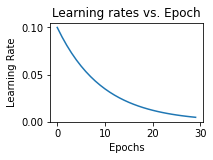

In [148]:
def plot_results(history, lrs):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(221)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(222)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(223)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
    
    plt.subplot(224)
    plt.plot(lrs)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate')
    plt.title('Learning rates vs. Epoch')
    plt.show()
              
plot_results(history, lrs)

In [149]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [150]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


In [151]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 73.4 %
Accuracy for class: car   is 79.1 %
Accuracy for class: bird  is 57.9 %
Accuracy for class: cat   is 54.6 %
Accuracy for class: deer  is 62.6 %
Accuracy for class: dog   is 63.5 %
Accuracy for class: frog  is 78.7 %
Accuracy for class: horse is 71.5 %
Accuracy for class: ship  is 75.9 %
Accuracy for class: truck is 74.4 %
